---
WGAN with gradient penalty to satisfy Lipschitz constraint.
DCGAN is used as base architecture of the networks.

---

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import Image as DisplayImage
from PIL import Image as PILImage
import torch.nn as nn
import torch.nn.functional as F
from fastai.vision import *
from fastai.vision.gan import *

You should set the following option to True if the notebook isn't located in the file system inside a clone of the git repo (with the needed Python modules available) it belongs to; i.e., it's running independently.

In [0]:
run_as_standalone_nb = True

In [5]:
# This cell needs to be executed before importing local project modules, like import core.gan
if run_as_standalone_nb:
    root_lib_path = os.path.abspath('generative-lab')
    if not os.path.exists(root_lib_path):
        !git clone https://github.com/davidleonfdez/generative-lab.git
    if root_lib_path not in sys.path:
        sys.path.insert(0, root_lib_path)
else:
    import local_lib_import

Cloning into 'generative-lab'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 503 (delta 1), reused 6 (delta 1), pack-reused 492
Receiving objects: 100% (503/503), 407.30 MiB | 33.53 MiB/s, done.
Resolving deltas: 100% (243/243), done.
Checking out files: 100% (51/51), done.


In [0]:
# Local project modules. Must be imported after local_lib_import or cloning git repo.
from core.gan import (GANGPLearner, GeneratorFuncStateLoader, GenImagesSampler, load_gan_generator, 
                      load_gan_learner, save_gan_learner)
from core.gan_display import display_gan_out_tensor
from core.gan_metrics import evaluate_models_fid, EvaluationItem, FIDCalculator
from core.gen_utils import PrinterProgressTracker
from core.nb_utils import mount_gdrive, output_file_link
from core.net_builders import custom_critic

In [0]:
# Point this variable to the path where you want to save your models
models_root = './'

In [0]:
img_size = 64
img_n_channels = 3
batch_size = 128
# Gradient penalty coefficient
plambda = 10

# DATA

In Kaggle, you can easily add the CelebA dataset. For other environments, you probably need to manually download the dataset from https://drive.google.com/open?id=0B7EVK8r0v71pWEZsZE9oNnFzTm8

In [0]:
real_images_path = Path('/kaggle/input/celeba-dataset/img_align_celeba/')
real_images_path

PosixPath('/kaggle/input/celeba-dataset/img_align_celeba')

In [0]:
sample_img_path = next(real_images_path.glob('**/*.jpg'))
sample_img_path

PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/018484.jpg')

In [0]:
im = PILImage.open(sample_img_path)
im.size

(178, 218)

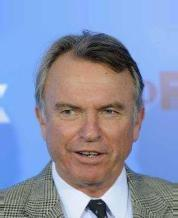

In [0]:
DisplayImage(filename=str(sample_img_path))

In [0]:
def get_data(path, bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=0.5, col_pct=0.5)], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

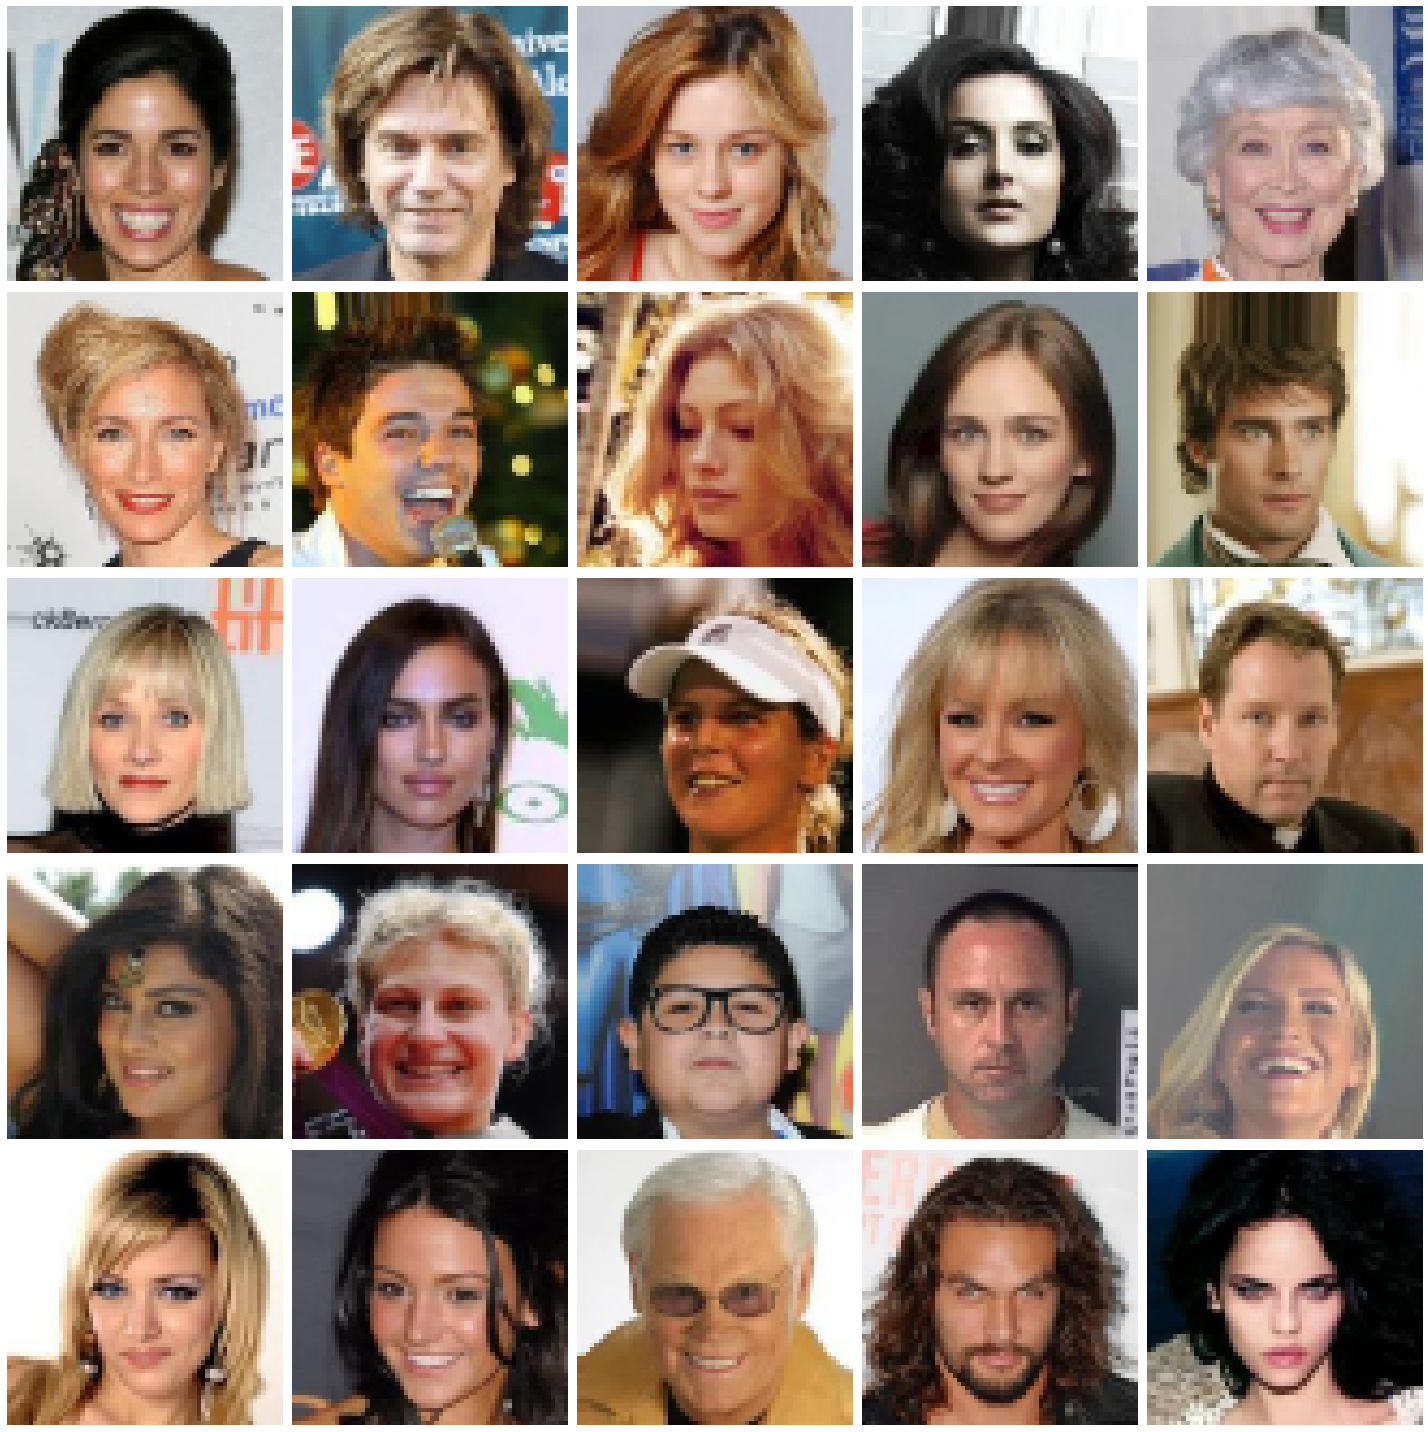

In [0]:
data = get_data(real_images_path, batch_size, img_size)
data.show_batch()

# CRITIC

`basic_critic(in_size: int, n_channels: int, n_features: int=64, n_extra_layers: int=0, **conv_kwargs)`

In [0]:
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)

# GENERATOR

`basic_generator(in_size: int, n_channels: int, noise_sz: int=100, n_features: int=64, n_extra_layers=0, **conv_kwargs)`

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)

# TRAINING

## TR 1: lambda = 10

In [0]:
plambda = 10

### TR 1a: lr=2e-4

In [0]:
lr = 2e-4
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1a_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1a_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1a_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1a_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
This way we can generate images in a session other than when we ran learner.fit():

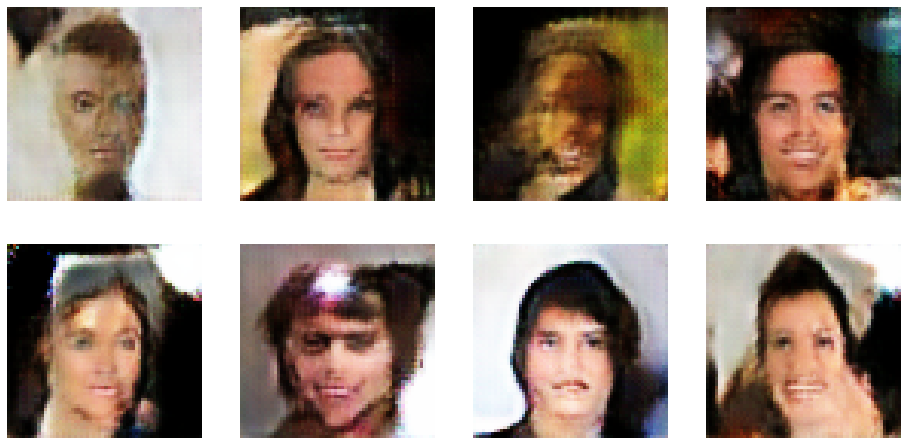

In [15]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan-gp-celeba-tr1a_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

### TR 1b: lr=5e-4

In [0]:
lr = 5e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1b_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1b_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1b_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1b_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Sample images generated after returning to work:

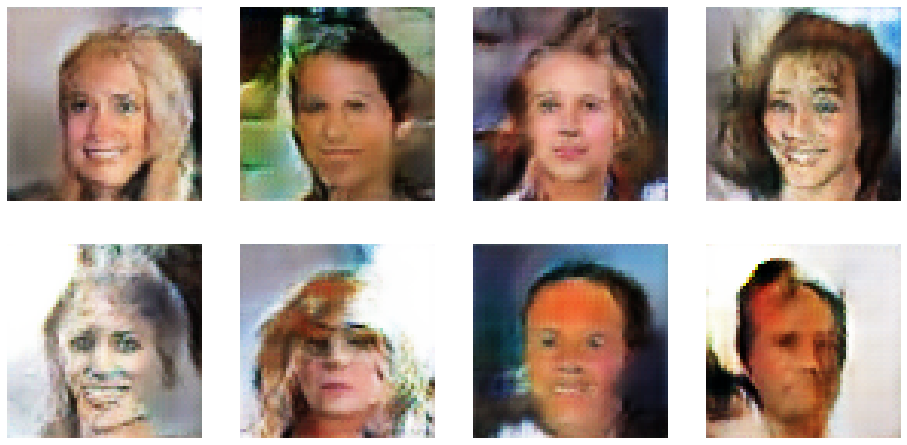

In [16]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan-gp-celeba-tr1b_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

### TR 1C: lr=5e-4, without batch norm in discriminator

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=None)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1c_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1c_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1c_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr1c_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Sample images generated after returning to work:

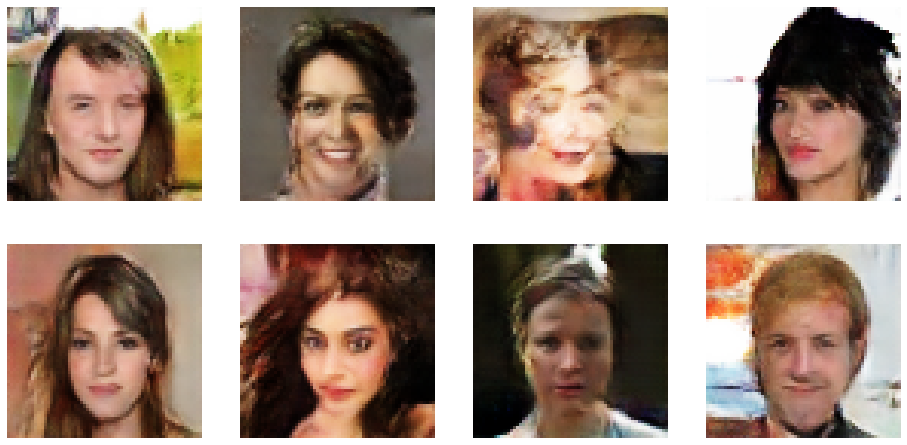

In [17]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan-gp-celeba-tr1c_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## TR 2: lambda = 50

In [0]:
plambda = 50

### TR 2a: lr=2e-4

In [0]:
lr = 2e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr2a_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 2b: lr=5e-4

In [0]:
lr = 5e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr2b_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 2C: lr=5e-4, without batch norm in discriminator

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=None)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-90.304245,#na#,110.320793,-119.948448,12:13
1,-101.100403,#na#,-58.159882,-104.890564,10:07
2,-74.437370,#na#,-71.012360,-79.515343,09:43
3,-68.533417,#na#,-76.994789,-65.964134,09:44
4,-56.351910,#na#,-64.402725,-56.666859,09:41


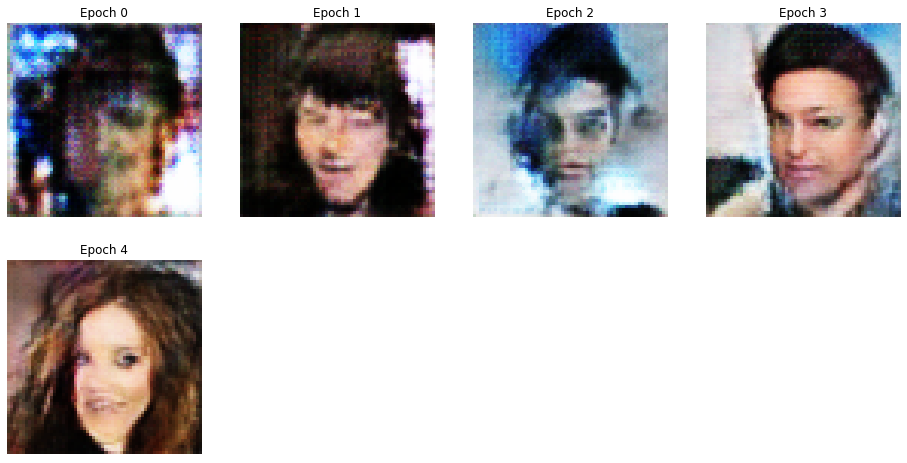

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr2c_5ep.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-53.681759,#na#,-68.924309,-51.417316,10:17
1,-52.240948,#na#,-71.765503,-47.032005,10:25
2,-45.711845,#na#,-69.524948,-44.086071,10:40
3,-46.186298,#na#,-66.679657,-41.573303,10:47
4,-44.400139,#na#,-66.498840,-39.008614,15:26


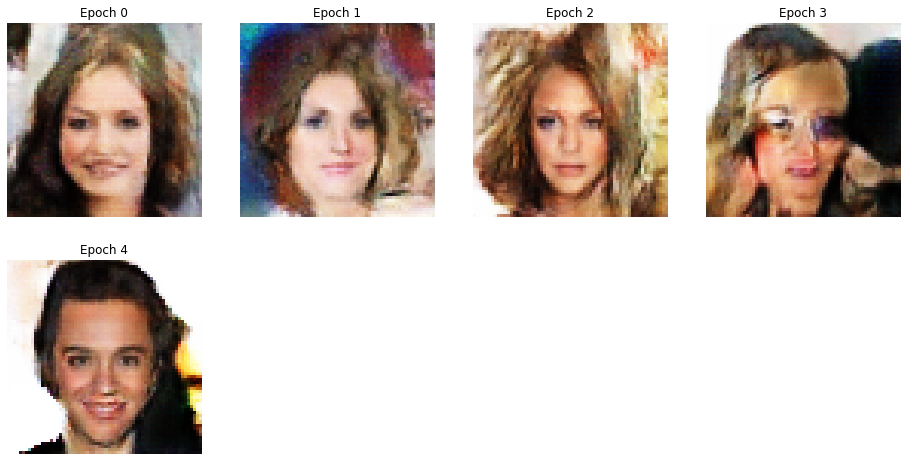

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr2c_10ep.pth')

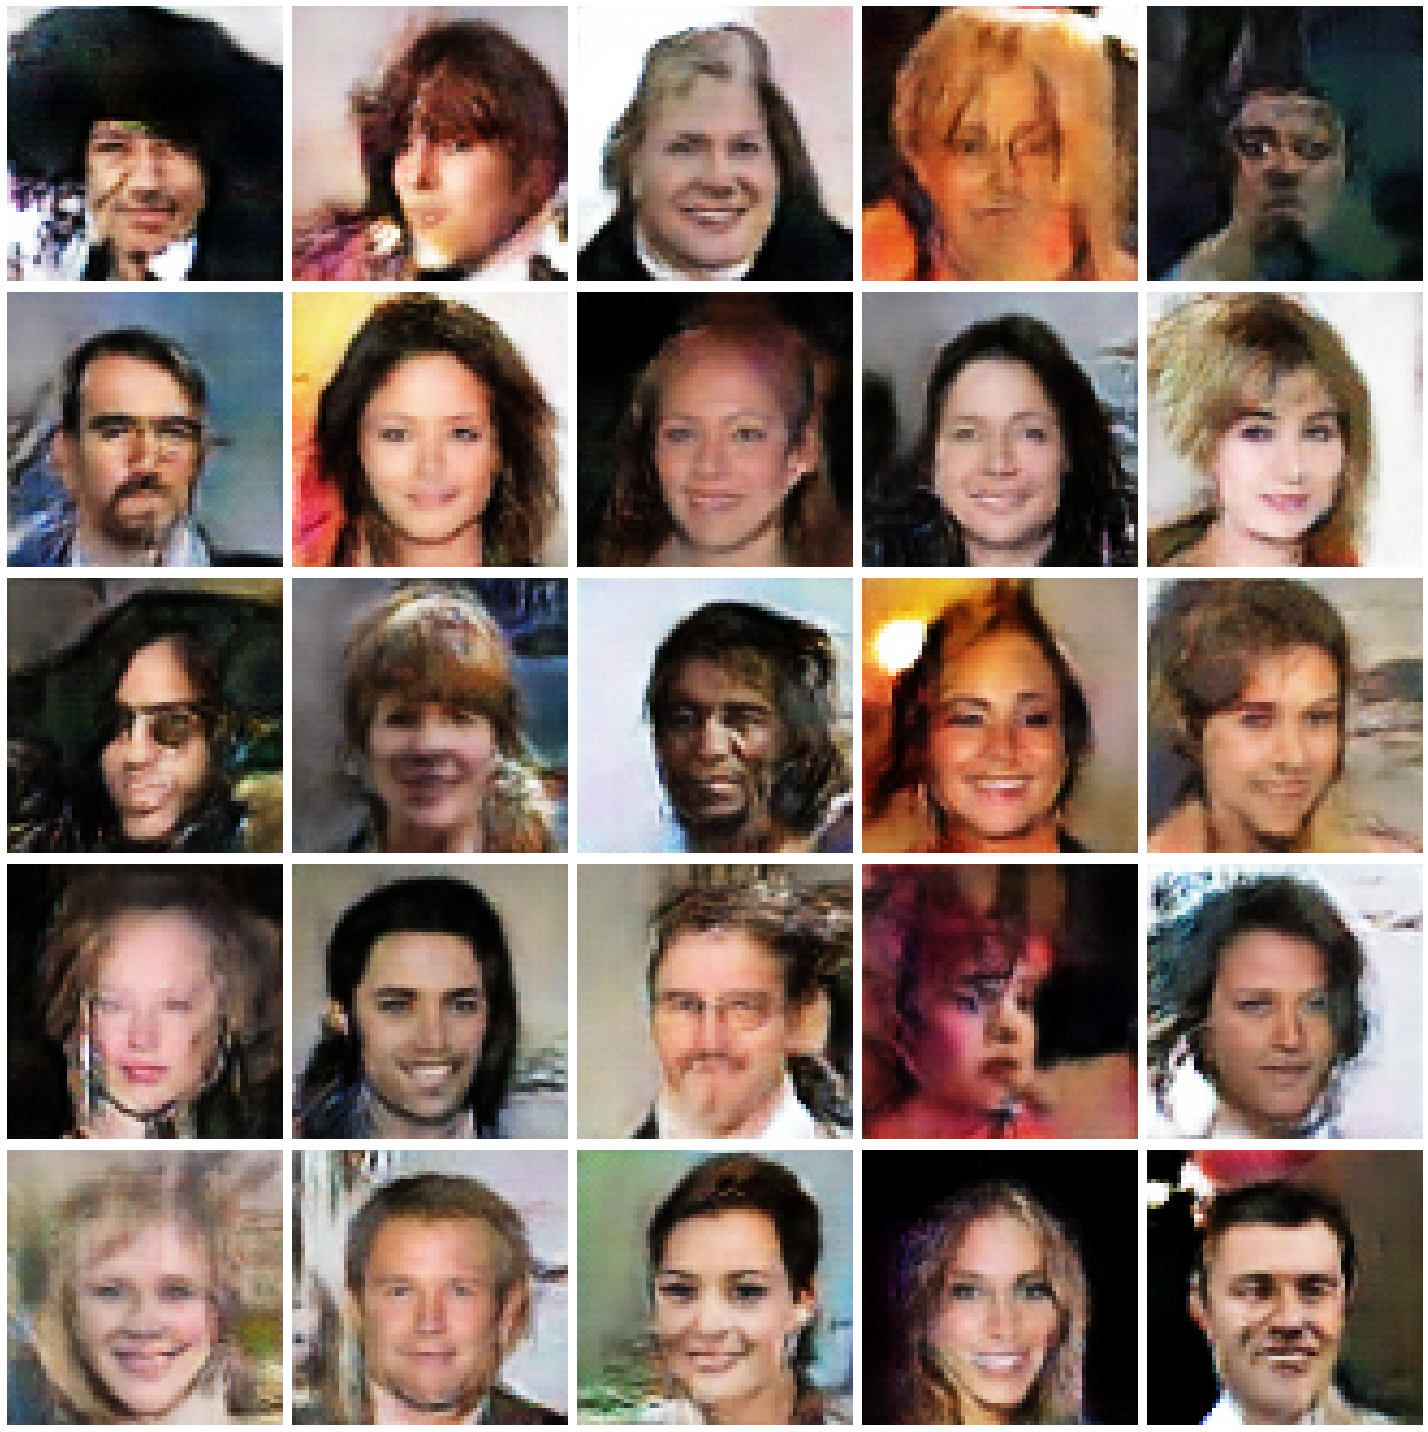

In [0]:
learner.show_results(ds_type=DatasetType.Train)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-39.528870,#na#,-53.317986,-38.033344,10:24
1,-37.483562,#na#,-53.050507,-35.628155,10:33
2,-36.157234,#na#,-52.774532,-34.470566,10:25
3,-36.159019,#na#,-55.518219,-33.181595,10:32
4,-36.584465,#na#,-55.985828,-32.701508,10:33


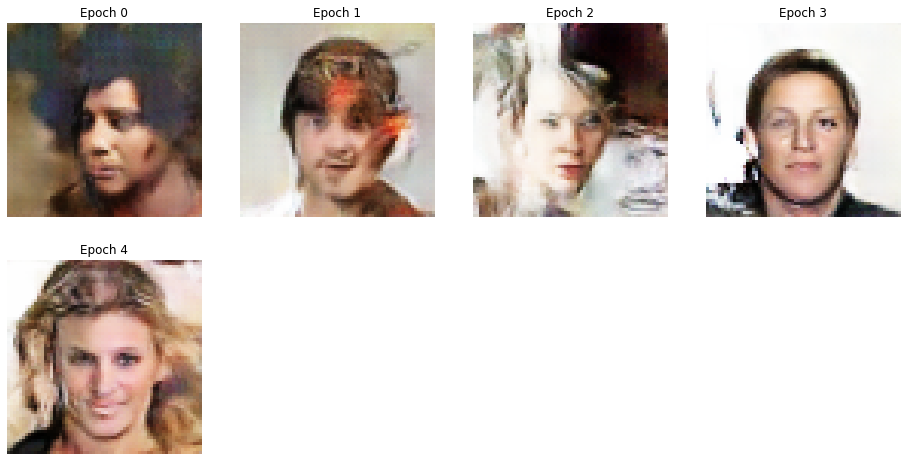

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr2c_15ep.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-37.531914,#na#,-63.680542,-31.060217,10:41
1,-33.885719,#na#,-56.616013,-30.241869,10:37
2,-35.440666,#na#,-59.265839,-30.095428,10:38
3,-33.503960,#na#,-61.203987,-28.957748,10:14
4,-34.172058,#na#,-66.223053,-28.507860,10:17


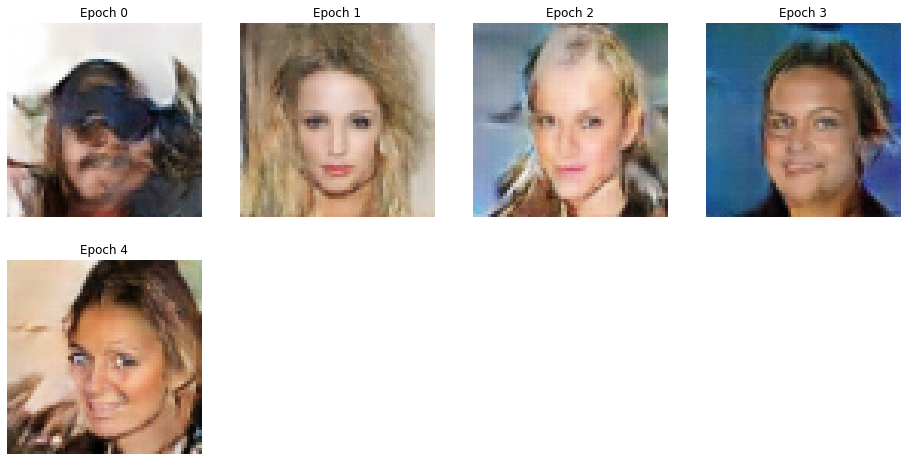

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr2c_20ep.pth')

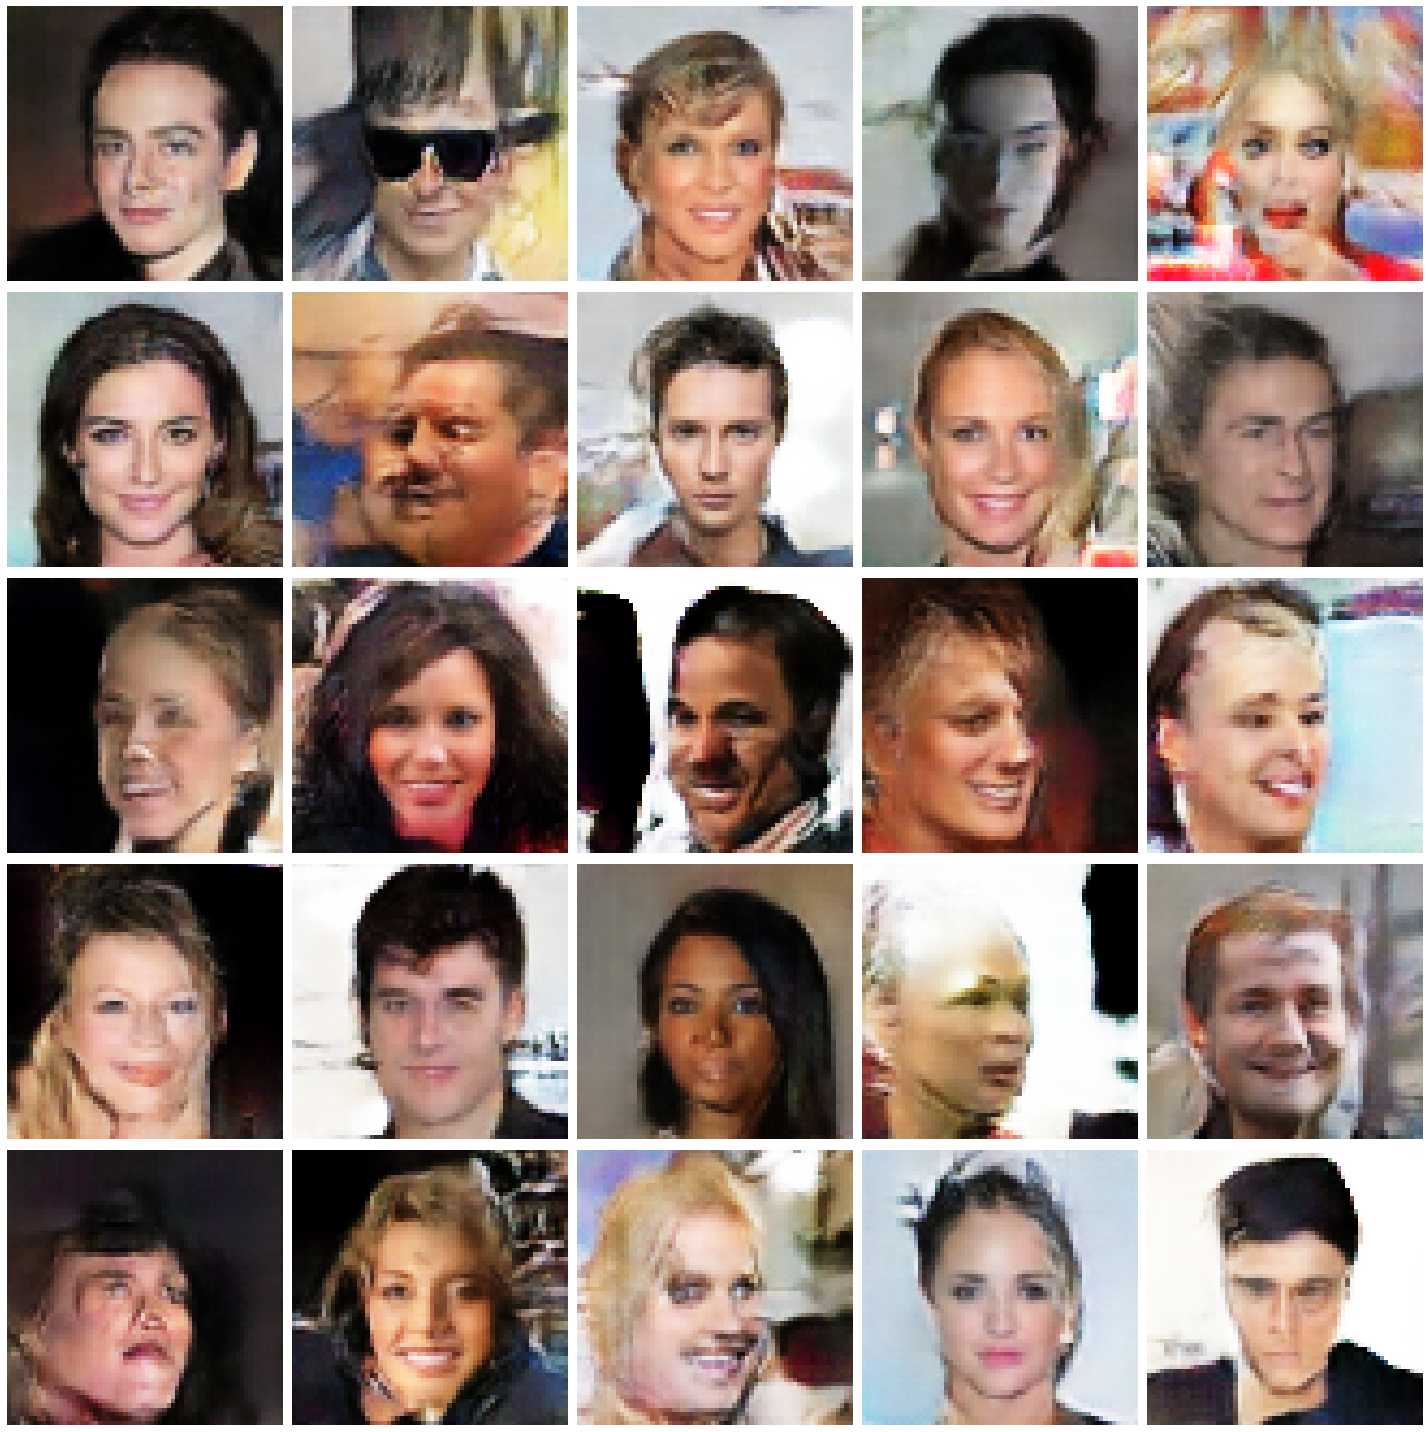

In [0]:
learner.show_results(ds_type=DatasetType.Train)

## TR 3: lambda = 2

In [0]:
plambda = 2

### TR 3a: lr=2e-4

In [0]:
lr = 2e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr3a_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 3b: lr=5e-4

In [0]:
lr = 5e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr3b_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 3C: lr=5e-4, without batch norm in discriminator

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=None)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr3c_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr3c_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr3c_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr3c_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Sample images generated after returning to work:

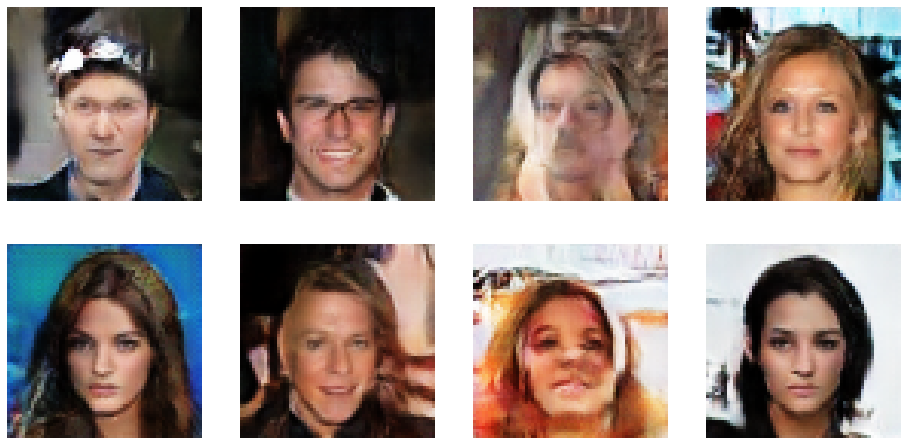

In [18]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan-gp-celeba-tr3c_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## TR 4: lambda = 0.5

In [0]:
plambda = 0.5

### TR 4a: lr=2e-4

In [0]:
lr = 2e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr4a_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 4b: lr=5e-4

In [0]:
lr = 5e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr4b_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 4C: lr=5e-4, without batch norm in discriminator

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=None)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr4c_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr4c_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr4c_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr4c_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Sample images generated after returning to work:

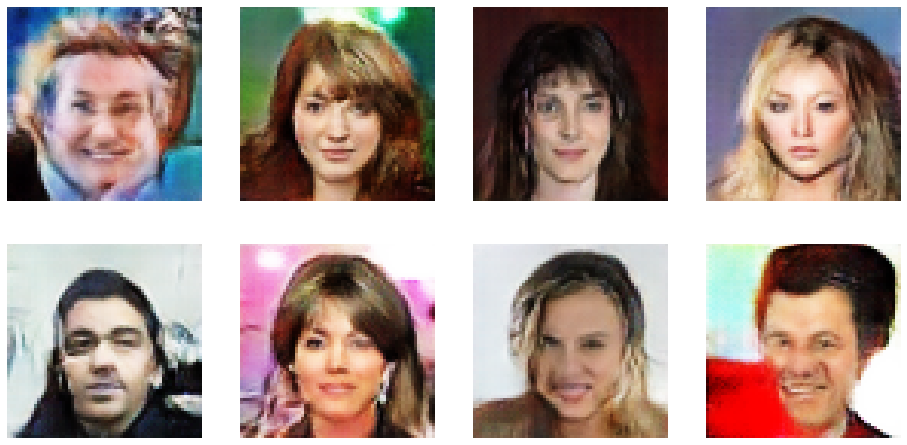

In [19]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan-gp-celeba-tr4c_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## TR 5: lambda = 0.1

In [0]:
plambda = 0.1

### TR 5a: lr=2e-4

In [0]:
lr = 2e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr5a_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 5b: lr=5e-4

In [0]:
lr = 5e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr5b_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 5C: lr=5e-4, without batch norm in discriminator

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=None)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr5c_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr5c_10ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr5c_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr5c_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Sample images generated after returning to work:

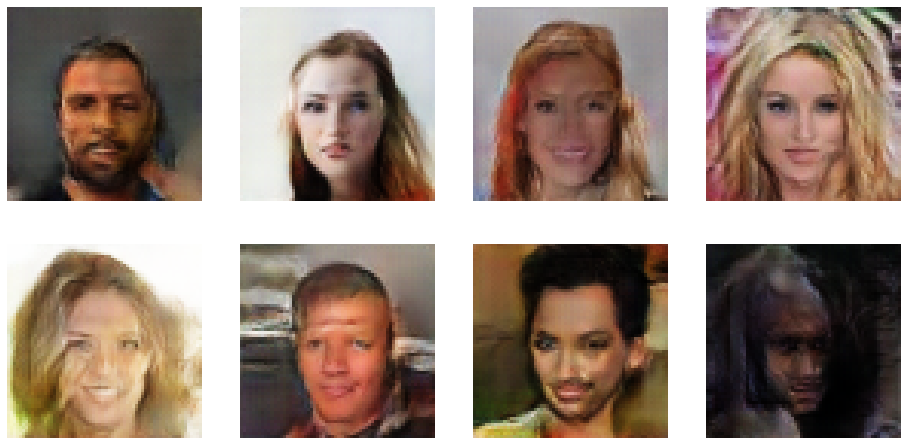

In [20]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan-gp-celeba-tr5c_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## TR 6: lambda = 250

In [0]:
plambda = 250

### TR 6a: lr=2e-4

In [0]:
lr = 2e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr6a_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 6b: lr=5e-4

In [0]:
lr = 5e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr6b_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 6C: lr=5e-4, without batch norm in discriminator

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=None)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr6c_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr6c_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr6c_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr6c_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Sample images generated after returning to work:

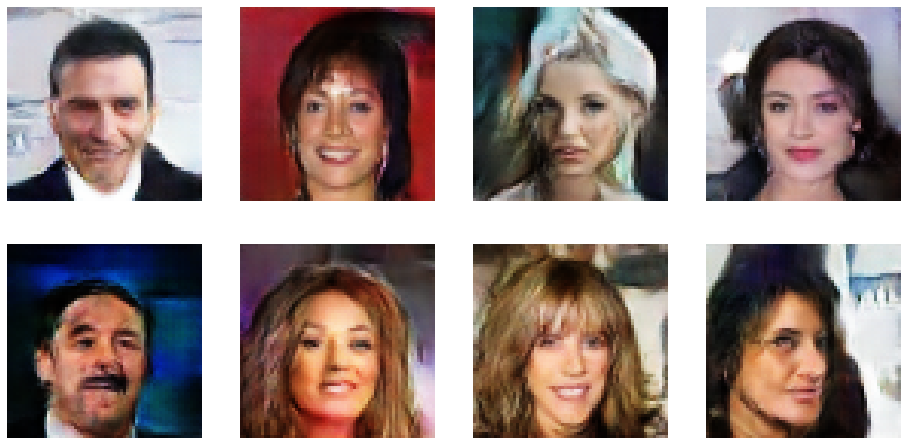

In [22]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'wgan-gp-celeba-tr6c_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## TR 7: lambda = 50000

In [0]:
plambda = 50000

### TR 7a: lr=2e-4

In [0]:
lr = 2e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr7a_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 7b: lr=5e-4

In [0]:
lr = 5e-4
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr7b_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TR 7C: lr=5e-4, without batch norm in discriminator

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=None)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = GANGPLearner.wgan(data, generator, critic, switch_eval=False, 
                            opt_func = partial(optim.Adam, betas = (0.,0.99)), 
                            wd=0., plambda=plambda)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr7c_5ep.pth')

Quite blurry, as expected. No need to go on.

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr7c_10ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr7c_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'wgan-gp-celeba-tr7c_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

# RESULTS EVALUATION

In [0]:
calculator = FIDCalculator()

In [2]:
model_ids = ['1a', '1b'] + [str(i)+'c' for i in range(1, 7)]
model_ids

['1a', '1b', '1c', '2c', '3c', '4c', '5c', '6c']

In [0]:
models_root = Path('../input/weights/')

In [0]:
n_total_imgs = 10000
n_imgs_by_group = 500

models = [EvaluationItem(model_id, basic_generator, [img_size, img_n_channels], {'n_extra_layers': 1})
          for model_id in model_ids]

def resolve_state_path(model_id:str):
    return f'{models_root}/wgan-gp-celeba-tr{model_id}_20ep.pth'

results = evaluate_models_fid(models, data, GeneratorFuncStateLoader(resolve_state_path),
                              n_total_imgs, n_imgs_by_group, calculator, PrinterProgressTracker())

In [0]:
results

* Completed model 1a with FID=86.57878112792969, std=1.8139246702194214
* Completed model 1b with FID=79.94417572021484, std=2.0265207290649414
* Completed model 1c with FID=41.13249206542969, std=1.3997259140014648
* Completed model 2c with FID=41.534996032714844, std=1.4056360721588135
* Completed model 3c with FID=41.34931945800781, std=1.3831844329833984
* Completed model 4c with FID=41.479522705078125, std=1.2283565998077393
* Completed model 5c with FID=42.12774658203125, std=1.245024561882019
* Completed model 6c with FID=**38.51847839355469**, std=0.8426231741905212 (**lambda = 250**)

# FINDINGS AND FACTS

*   Recommended value of lambda = 10 works pretty well. Probably anything between 0.1-250 is ok. Best value here seems to be at the higher end of the range.
*   As stated in the paper, batch norm shouldn't be used in the critic network. So, executions tagged with TR [number]A or TR [number]B (like TR 2A, TR 3B, ...)aren't theoretically right; only those ending with C and subsequent letters are OK. This is clearly confirmed by the FID.
  * With batch norm, some results are gotten anyway but the convergence is slower and less smooth.

